In [93]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
from tensorflow.keras import layers, models
import sklearn.metrics as metrics

%matplotlib notebook

In [2]:
data_root = Path('.')/'data'

In [3]:
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1621503': 84,
 's1704037': 80,
 's1701688': 84,
 's1737472': 0,
 's1758009': 78,
 's1710228': 78,
 's1660711': 36,
 's1655560': 78,
 's2017768': 8,
 's1721039': 76,
 's1746788': 84,
 's1711507': 97,
 's1642301': 84,
 's1764751': 20,
 's1616573': 94}

In [103]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

LABELS = {
    0:  "Sitting",
    1:  "Sitting bent forward",
    2:  "Sitting bent backward",
    3:  "Walking at normal speed",
    4:  "Standing",
    5:  "Lying down on back",
    6:  "Lying down left",
    7:  "Lying down right",
    8:  "Lying down on stomach",
    9:  "Movement",
    10: "Running",
    11: "Climbing stairs",
    12: "Descending stairs",
    13: "Desk work"
}

In [5]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = ACTIVITY_CODE_TO_TFCODE_MAPPING[int(self.act_code)]


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [6]:
def plot_respeck_fig(df):
  fig = plt.figure(figsize=(10, 8))
  plt.plot(df['accel_x'], label="accel_x")
  plt.plot(df['accel_y'], label="accel_y")
  plt.plot(df['accel_z'], label="accel_z")
  plt.legend()
  return plt

In [7]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Wrist', sensor_side='Right', act_type='Lying down right', act_code=7, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601826499860    0  0.080566 -0.230530 -0.979065
1    1601826499938    1  0.081055 -0.230042 -0.978577
2    1601826500017    2  0.084961 -0.233215 -0.978333
3    1601826500096    3  0.083740 -0.231750 -0.979797
4    1601826500175    4  0.084473 -0.232483 -0.981750
..             ...  ...       ...       ...       ...
411  1601826532226  411  0.060547 -0.211487 -0.983704
412  1601826532305  412  0.060547 -0.207825 -0.989075
413  1601826532383  413  0.060303 -0.204407 -0.987366
414  1601826532462  414  0.061279 -0.208313 -0.986145
415  1601826532541  415  0.061523 -0.207092 -0.984924

[416 rows x 5 columns])

In [8]:
keys = ["accel_x", "accel_y", "accel_z"]

In [9]:
window_size = 100
step_size = 5

In [10]:
sensor_pos = 'Chest'
sensor_side = 'Right'

In [11]:
# split students into train and test set

students = list(files.keys())
    
split = int(len(students) * 0.8)
train_students = students[:split]
test_students = students[split:]


In [12]:
test_students

['s1642301', 's1764751', 's1616573']

In [13]:
def get_activities(files, students, window_size, sensor_pos, sensor_side):
    student_files = [files[student] for student in students]
    
    activities = [read_custom_file(filename) for student in student_files for filename in student]
    activities = [activity for activity in activities if not activity.df.empty and len(activity.df.index) >= window_size and activity.header.sensor_pos == sensor_pos and activity.header.sensor_side == sensor_side]
    
    return activities

In [14]:
train_activities = get_activities(files, train_students, window_size, sensor_pos, sensor_side)

test_activities = get_activities(files, test_students, window_size, sensor_pos, sensor_side)


In [15]:
# X = data
# Y = labels

def create_data_arrays(activities):
    data = np.array([activity.df.get(keys).values for activity in activities], dtype=object)
    labels = np.array([activity.header.act_code for activity in activities])
    
    return data, labels

In [96]:
train_data_raw, train_labels_raw = create_data_arrays(train_activities)

test_data_raw, test_labels_raw = create_data_arrays(test_activities)


In [97]:
# one hot encoding of output labels

train_labels = np.array(pd.get_dummies(train_labels_raw))
test_labels = np.array(pd.get_dummies(test_labels_raw))

In [18]:
def standardize(X):
    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    return x

def standardize_array(data_raw):
    data = np.zeros(data_raw.shape, dtype=object)
    
    for i in range(len(data)):
        data[i] = (standardize(data_raw[i]))
        
    return data

In [29]:
# standardize input data

train_data = train_data_raw # standardize_array(train_data_raw)

test_data = test_data_raw # standardize_array(test_data_raw)

In [30]:
def window_data(data_array, label_array, window_size, step_size):
    windowed_data = []
    windowed_labels = []
    
    for i in range(len(label_array)):
        arr = data_array[i]
        label = label_array[i]
        start_i = 0
        end_i = start_i + window_size

        while end_i < arr.shape[0]:
            windowed_data.append(arr[start_i:end_i])
            windowed_labels.append(label)
            start_i = start_i + step_size
            end_i = start_i + window_size
        
    return np.array(windowed_data), np.array(windowed_labels)

In [31]:
train_data_win, train_label_win = window_data(train_data, train_labels, window_size, step_size)

test_data_win, test_label_win = window_data(test_data, test_labels, window_size, step_size)

print(train_data_win.shape)
print(train_label_win.shape)

print(test_data_win.shape)
print(test_label_win.shape)

(10384, 100, 3)
(10384, 14)
(2684, 100, 3)
(2684, 14)


In [32]:
# variable length inputs
# use batch size = 1

x = train_data_win
y = train_label_win

learn_rate = 0.0001
batch_size = 600
num_epochs = 1500

num_channels = x.shape[2]
num_classes = y.shape[1]

seq_len = x.shape[1]

num_inputs = x.shape[0]
num_outputs = y.shape[0]

In [138]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 0, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy

In [128]:
# fit and evaluate a model
def evaluate_model_2(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 0, 30, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy

In [34]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [139]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    models = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy, r)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        models.append
    # summarize results
    summarize_results(scores)
    
def save_model(model, n):
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    model_filename = 'cnn_model_epochs40_' + str(n) + '_' + sensor_pos + '_' + sensor_side + '.tflite' 
    # Save the model.
    with open(model_filename, 'wb') as f:
        f.write(tflite_model)

In [140]:
run_experiment(train_data_win, train_label_win, test_data_win, test_label_win, 5)

>#1: 39.829
>#2: 32.824
>#3: 42.325
>#4: 46.461
>#5: 43.666
[39.82861340045929, 32.82414376735687, 42.324888706207275, 46.460506319999695, 43.66616904735565]
Accuracy: 41.021% (+/-4.624)


In [78]:
def get_predictions_from_saved_model(model_filename, testX):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for x in testX:
        interpreter.set_tensor(input_details[0]['index'], [x])
    
        interpreter.invoke()
    
        predictions.append(interpreter.get_tensor(output_details[0]['index']))
    
    return np.array(predictions)

In [79]:
predictions = get_predictions_from_saved_model('cnn_model_4ChestRight.tflite', np.array(test_data_win, dtype=np.float32))

In [81]:
predictions.shape

(2684, 1, 14)

In [82]:
classes = {'sitting': [0, 1, 2], 
           'standing': [4], 
           'lying': [5, 6, 7, 8],
           'walking': [3],
           'movement': [9],
           'running': [10],
           'climbing_stairs':[11],
           'descending_stairs': [12],
           'desk_work': [13]}


In [100]:
pred_labels = np.argmax(predictions, axis=2)

array([ 0,  7, 10, 13,  4,  3,  8,  5,  9, 12, 11,  2,  6,  1,  1, 13, 13,
        0,  1,  4,  2,  0,  2,  4, 13,  6,  3,  5, 11,  8,  0,  2,  1, 11,
        0, 12, 10, 13,  7, 12])

<IPython.core.display.Javascript object>


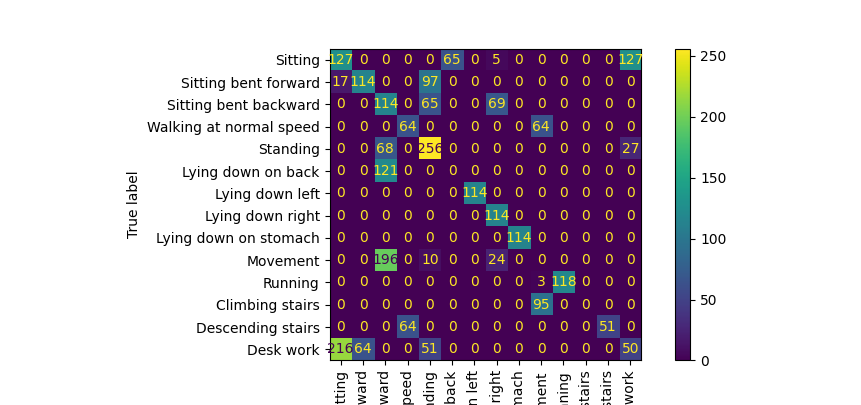

In [115]:
cm = metrics.confusion_matrix(np.argmax(test_label_win, axis=1), pred_labels)

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
disp.plot(xticks_rotation='vertical')
plt.show()